In [177]:
import os
import tensorflow as tf
import tensorflow_probability as tfp
tfpl = tfp.layers
tf1 = tf.compat.v1
tfd = tfp.distributions
import numpy as np
import matplotlib.pyplot as plt
import h5py
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [178]:
from tensorflow_probability.python.distributions import kl_divergence

In [179]:
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout

In [180]:
gpus = tf.config.list_physical_devices('GPU')

if gpus:
  # Restrict TensorFlow to only allocate 10GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5000)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [181]:
hf = h5py.File('/mnt/data/HSC/HSC_v6/extra_files/five_band_image127x127_full.hdf5', 'r')

In [182]:
n = 5000

In [183]:
x = np.asarray(hf["image"][0:n]).astype('float32')
y = np.asarray(hf["specz"][0:n]).astype('float32')

In [184]:
y = y[:,0]

In [185]:
x.shape

(5000, 5, 127, 127)

In [186]:
x = np.transpose(x,(0,2,3,1))
max_value = np.max(x)
min_value = np.min(x)
x_new = np.true_divide(np.subtract(x,min_value),max_value - min_value)

In [187]:
hf.close()

In [188]:
x_train, x_test, y_train, y_test = train_test_split(x_new,y,test_size=0.2)

In [189]:
kl_divergence_function = lambda q, p, _: kl_divergence(q, p) / n

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='tanh',input_shape=(120,120,5)))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(32, kernel_size=(2,2),activation='tanh'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(32, kernel_size=(3,3),activation='relu'))
model.add(Conv2D(32, kernel_size=(2,2),activation='relu'))
model.add(Flatten())
model.add(Dense(500, activation="tanh"))
model.add(Dense(100, activation="tanh"))
model.add(Dense(1))

In [190]:
def posterior_mean_field(kernel_size: int, bias_size: int, dtype: any) -> tf.keras.Model:
    """Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`."""
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.))

    return tf.keras.Sequential([
        tfp.layers.VariableLayer(2 * n, dtype=dtype, initializer=lambda shape, dtype: random_gaussian_initializer(shape, dtype), trainable=True),
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc=t[..., :n],
                       scale= + 10e-4*tf.nn.softplus(c + t[..., n:])),
            reinterpreted_batch_ndims=1)),
    ])

def prior_trainable(kernel_size: int, bias_size: int, dtype: any) -> tf.keras.Model:
    """Specify the prior over `keras.layers.Dense` `kernel` and `bias`."""
    n = kernel_size + bias_size

    return tf.keras.Sequential([
        tfp.layers.VariableLayer(n, dtype=dtype),  # Returns a trainable variable of shape n, regardless of input
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc=t, scale=1),
            reinterpreted_batch_ndims=1)),
    ])

def random_gaussian_initializer(shape, dtype):
    n = int(shape / 2)
    loc_norm = tf.random_normal_initializer(mean=0., stddev=0.1)
    loc = tf.Variable(
        initial_value=loc_norm(shape=(n,), dtype=dtype)
    )
    scale_norm = tf.random_normal_initializer(mean=-3., stddev=0.1)
    scale = tf.Variable(
        initial_value=scale_norm(shape=(n,), dtype=dtype)
    )
    return tf.concat([loc, scale], 0)

def negative_loglikelihood(targets, estimated_distribution):
    return -estimated_distribution.log_prob(targets)

In [191]:
model_variational = Sequential([
    tf.keras.Input(shape=(127,127,5),name="basket"),
    
    tfp.layers.Convolution2DFlipout(32, kernel_size=(2,2), activation='tanh', 
                                    kernel_divergence_fn=kl_divergence_function),
    MaxPooling2D(2,2),
    
    tfp.layers.Convolution2DFlipout(32, kernel_size=(2,2), activation='tanh', 
                                    kernel_divergence_fn=kl_divergence_function),
    MaxPooling2D(2,2),
    
    tfp.layers.Convolution2DFlipout(32, kernel_size=(2,2), activation='relu', 
                                    kernel_divergence_fn=kl_divergence_function),
    
    tfp.layers.Convolution2DFlipout(32, kernel_size=(2,2), activation='relu', 
                                    kernel_divergence_fn=kl_divergence_function),
    tf.keras.layers.Flatten(),
    # tfp.layers.DenseVariational(512, activation='tanh', make_posterior_fn=posterior_mean_field, make_prior_fn=prior_trainable, kl_weight=1/n),
    Dense(512, activation='tanh'),
    # tfp.layers.DenseVariational(128, activation='tanh', make_posterior_fn=posterior_mean_field, make_prior_fn=prior_trainable, kl_weight=1/n),
    Dense(128, activation='tanh'),
    Dense(2),
    tfp.layers.IndependentNormal(1)
])

model_variational.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout_56 (Conv2DFli (None, 126, 126, 32)      1312      
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_flipout_57 (Conv2DFli (None, 62, 62, 32)        8224      
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_flipout_58 (Conv2DFli (None, 30, 30, 32)        8224      
_________________________________________________________________
conv2d_flipout_59 (Conv2DFli (None, 29, 29, 32)        8224      
_________________________________________________________________
flatten_13 (Flatten)         (None, 26912)            

divergence_fn = lambda q,p,_:kl_divergence(q,p)/(n)

model_variational = Sequential([
    
    tfpl.Convolution2DReparameterization(input_shape = (120,120,5), filters = 32, kernel_size = (2,2), activation='tanh',
                                           kernel_prior_fn = tfpl.default_mean_field_normal_fn(is_singular=False,loc_initializer=tf1.initializers.random_normal(stddev=1e-4)),
                                           kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False,loc_initializer=tf1.initializers.random_normal(stddev=1e-4)),
                                           kernel_divergence_fn = divergence_fn,
                                           bias_prior_fn = tfpl.default_mean_field_normal_fn(is_singular=False,loc_initializer=tf1.initializers.random_normal(stddev=1e-4)),
                                           bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False,loc_initializer=tf1.initializers.random_normal(stddev=1e-4)),
                                           bias_divergence_fn = divergence_fn),
    MaxPooling2D(2,2),
    Conv2D(32, (2,2), activation='tanh'),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation='relu'),
    Conv2D(32, (2,2), activation='relu'),
    Flatten(),
    Dense(512, activation='tanh'),
    Dense(128, activation='tanh'),
    tfpl.DenseReparameterization(2, activation=None, kernel_prior_fn = tfpl.default_mean_field_normal_fn(is_singular=False,loc_initializer=tf1.initializers.random_normal(stddev=1e-4)), kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False,loc_initializer=tf1.initializers.random_normal(stddev=1e-4)), kernel_divergence_fn = divergence_fn, bias_prior_fn = tfpl.default_mean_field_normal_fn(is_singular=False,loc_initializer=tf1.initializers.random_normal(stddev=1e-4)), bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False,loc_initializer=tf1.initializers.random_normal(stddev=1e-4)), bias_divergence_fn = divergence_fn),
    tfp.layers.IndependentNormal(1)
    
])
model_variational.summary()

In [192]:
def negative_loglikelihood(targets, estimated_distribution):
    return -estimated_distribution.log_prob(targets)

model_variational.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), loss = negative_loglikelihood, metrics=[keras.metrics.RootMeanSquaredError()])

In [193]:
model_variational.fit(x = x_train, y = y_train, epochs = 300, shuffle = True, verbose=1)

Epoch 1/300
125/125 [==============================] - 3s 12ms/step - loss: 179718979584.0000 - root_mean_squared_error: 23.8033
Epoch 2/300
125/125 [==============================] - 1s 12ms/step - loss: 33.5081 - root_mean_squared_error: 28.0536
Epoch 3/300
125/125 [==============================] - 1s 11ms/step - loss: 33.5055 - root_mean_squared_error: 28.5075
Epoch 4/300
125/125 [==============================] - 1s 11ms/step - loss: 33.5052 - root_mean_squared_error: 28.6715
Epoch 5/300
125/125 [==============================] - 1s 12ms/step - loss: 33.5052 - root_mean_squared_error: 28.7649
Epoch 6/300
125/125 [==============================] - 1s 12ms/step - loss: 33.5051 - root_mean_squared_error: 28.8081
Epoch 7/300
125/125 [==============================] - 1s 11ms/step - loss: 33.5051 - root_mean_squared_error: 28.8435
Epoch 8/300
125/125 [==============================] - 1s 11ms/step - loss: 33.5051 - root_mean_squared_error: 28.8693
Epoch 9/300
125/125 [=================

125/125 [==============================] - 1s 11ms/step - loss: 33.5047 - root_mean_squared_error: 29.0197
Epoch 70/300
125/125 [==============================] - 1s 12ms/step - loss: 33.5047 - root_mean_squared_error: 29.0191
Epoch 71/300
125/125 [==============================] - 1s 12ms/step - loss: 33.5047 - root_mean_squared_error: 29.0189
Epoch 72/300
125/125 [==============================] - 2s 12ms/step - loss: 33.5046 - root_mean_squared_error: 29.0187
Epoch 73/300
125/125 [==============================] - 1s 12ms/step - loss: 33.5046 - root_mean_squared_error: 29.0192
Epoch 74/300
125/125 [==============================] - 1s 11ms/step - loss: 33.5046 - root_mean_squared_error: 29.0196
Epoch 75/300
125/125 [==============================] - 1s 11ms/step - loss: 33.5045 - root_mean_squared_error: 29.0195
Epoch 76/300
125/125 [==============================] - 1s 11ms/step - loss: 33.5045 - root_mean_squared_error: 29.0199
Epoch 77/300
125/125 [==============================]

125/125 [==============================] - 1s 12ms/step - loss: 33.4925 - root_mean_squared_error: 29.0221
Epoch 138/300
125/125 [==============================] - 1s 11ms/step - loss: 33.4917 - root_mean_squared_error: 29.0216
Epoch 139/300
125/125 [==============================] - 1s 11ms/step - loss: 33.4911 - root_mean_squared_error: 29.0213
Epoch 140/300
125/125 [==============================] - 1s 11ms/step - loss: 33.4907 - root_mean_squared_error: 29.0213
Epoch 141/300
125/125 [==============================] - 1s 11ms/step - loss: 33.4900 - root_mean_squared_error: 29.0215
Epoch 142/300
125/125 [==============================] - 1s 11ms/step - loss: 33.4871 - root_mean_squared_error: 29.0216
Epoch 143/300
125/125 [==============================] - 1s 11ms/step - loss: 33.4855 - root_mean_squared_error: 29.0216
Epoch 144/300
125/125 [==============================] - 1s 11ms/step - loss: 33.4840 - root_mean_squared_error: 29.0224
Epoch 145/300
125/125 [=======================

125/125 [==============================] - 1s 11ms/step - loss: 31.9302 - root_mean_squared_error: 29.0185
Epoch 205/300
125/125 [==============================] - 1s 11ms/step - loss: 31.8373 - root_mean_squared_error: 29.0181
Epoch 206/300
125/125 [==============================] - 1s 11ms/step - loss: 31.7255 - root_mean_squared_error: 29.0177
Epoch 207/300
125/125 [==============================] - 1s 11ms/step - loss: 31.6281 - root_mean_squared_error: 29.0177
Epoch 208/300
125/125 [==============================] - 1s 11ms/step - loss: 31.5030 - root_mean_squared_error: 29.0173
Epoch 209/300
125/125 [==============================] - 1s 11ms/step - loss: 31.3785 - root_mean_squared_error: 29.0169
Epoch 210/300
125/125 [==============================] - 1s 11ms/step - loss: 31.2475 - root_mean_squared_error: 29.0161
Epoch 211/300
125/125 [==============================] - 1s 11ms/step - loss: 31.1397 - root_mean_squared_error: 29.0156
Epoch 212/300
125/125 [=======================

125/125 [==============================] - 2s 12ms/step - loss: 14.5021 - root_mean_squared_error: 28.7846
Epoch 272/300
125/125 [==============================] - 2s 12ms/step - loss: 14.2485 - root_mean_squared_error: 28.7740
Epoch 273/300
125/125 [==============================] - 1s 12ms/step - loss: 14.0009 - root_mean_squared_error: 28.7627
Epoch 274/300
125/125 [==============================] - 1s 11ms/step - loss: 13.7578 - root_mean_squared_error: 28.7515
Epoch 275/300
125/125 [==============================] - 1s 11ms/step - loss: 13.5213 - root_mean_squared_error: 28.7402
Epoch 276/300
125/125 [==============================] - 1s 12ms/step - loss: 13.2905 - root_mean_squared_error: 28.7284
Epoch 277/300
125/125 [==============================] - 1s 12ms/step - loss: 13.0647 - root_mean_squared_error: 28.7160
Epoch 278/300
125/125 [==============================] - 1s 11ms/step - loss: 12.8451 - root_mean_squared_error: 28.7031
Epoch 279/300
125/125 [=======================

In [194]:
model_variational.predict(np.array([x_train[0],x_train[1]]))

array([[-15.6074705],
       [-13.557387 ]], dtype=float32)

In [211]:
model_variational(np.array([x_train[0]])).mean()[0][0]

<tf.Tensor: shape=(), dtype=float32, numpy=-16.951733>

In [208]:
y_train[0]

0.8994

In [197]:
y_test_prediction = []

for i in range(len(y_test)):
    y_test_prediction.append(model_variational(np.array([x_test[i]])).stddev()[0][0])

y_test_prediction = np.asarray(y_test_prediction).astype('float32')

y_test_spectro = np.asarray(y_test)

In [198]:
from scipy.stats import gaussian_kde
xy = np.asarray(np.vstack([y_test_spectro,y_test_prediction])).astype('float32')
z = gaussian_kde(xy)(xy)

(0.0, 2.0)

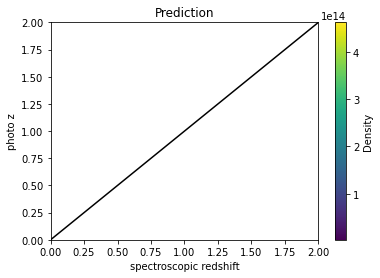

In [199]:
plt.rcParams.update({'font.size': 10})
fig, ax = plt.subplots()
scatter_plot = ax.scatter(y_test_spectro, y_test_prediction, c = z, s = 1, edgecolor = None)
plt.colorbar(scatter_plot, label = 'Density')
plt.title('Prediction')
plt.xlabel('spectroscopic redshift')
plt.ylabel('photo z')
plt.plot([0, 2], [0, 2],color = 'black')
plt.xlim([0, 2])
plt.ylim([0, 2])

In [200]:
# END